# GIS GZ – Übung 6: Geoprocessing mit Netzwerken – Critical Thinking

## Inhalt

Das Ziel dieses Teils der Übung ist es, Ihr kritisches Denken zu schärfen.

## Aufgabe 1

Der Code in der folgenden Zelle ist bereits aus Teil 2 bekannt:

In [1]:
import rasterio
from shapely.geometry import LineString
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import rasterio.plot as rplot
import os

default_lattice = [[((0, 0), 1.0 / 2.0), (( 0,  1), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), (( 1,  0), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), ((-1,  0), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), (( 0, -1), 1.0 / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), ((-1,  1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), (( 1,  1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), ((-1, -1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), (( 1, -1), np.sqrt(2) / 2.0)]
                  ]


def calc_least_cost_path(path, band=1, source_coord=(0, 0), target_coord=(0, 0), matrix=default_lattice):
    """
    Create a graph with the weighted edges based on the cost surface and compute the least cost path
    
    Args:
        path (str): Path to the input raster file that represents the cost surface
        band (int): The band of the raster file that contains the cost values
        source_coord (tuple): The coordinate pair of the source point, given in the same CRS as the cost surface
        target_coord (tuple): The coordinate pair of the target point, given in the same CRS as the cost surface
        matrix (list): The lattice (search kernel) used to determine the least cost neighbors
        
    
    Returns:
        The total costs and a LineString object of the least cost path
    """

    # Open Raster
    with rasterio.open(path) as src:

        fwd = src.transform
        data = src.read(band)
        NODATA = src.meta['nodata']

        print("-- Create Graph --")
        G = nx.DiGraph()


        # Create edges
        _edges = []

        for i in range(src.width):
            for j in range(src.height):

                for edge in matrix:

                    (start_i, start_j), _ = edge[0]
                    start_node = (start_i + i, start_j + j)

                    (end_i, end_j), _ = edge[-1]
                    end_node = (end_i + i, end_j + j)

                    # We only consider edges within the study area that have a value
                    if ((0 <= start_node[0] < src.width and 0 <= start_node[1] < src.height) and
                            (0 <= end_node[0] < src.width and 0 <= end_node[1] < src.height) and
                            (not data[j, i] == NODATA)):

                        # Calculate cost of edge
                        cost = 0.0
                        has_nodata = False
                        for k in edge:
                            (k_i, k_j), w_k = k
                            d = data[k_j + j, k_i + i]
                            if d == NODATA:
                                has_nodata = True
                                break
                            cost += d * w_k

                        if not has_nodata:
                            _edges.append((start_node, end_node, cost))

        G.add_weighted_edges_from(_edges)

        print("")
        print("\t Created graph with:")
        print("\t # Vertex: {}".format(G.number_of_nodes()))
        print("\t # Edges: {} ".format(G.number_of_edges()))
        print("")

        # Find shortest path and return total cost and LineString of found path
        print("-- Find shortest path --")
        source_node = tuple(map(int, ~fwd * source_coord))
        target_node = tuple(map(int, ~fwd * target_coord))

        tot_cost, path = nx.single_source_dijkstra(G,
                                                   source=source_node,
                                                   target=target_node,
                                                   weight='weight')

        _coords = []
        for p in path:
            # We add 0.5 to p to get coordinate of middle of corresponding cell
            x, y = fwd * (p[0] + 0.5, p[1] + 0.5)
            _coords.append((x, y))

        ls = LineString(_coords)

        print("")
        print("\t Found path with:")
        print("\t\t # Path costs: {}".format(tot_cost))
        print("\t\t # Path length: {} ".format(ls.length))
        print("")

    return tot_cost, ls


def plot_result(lss, cost_surface=None):
    """
    Plots the LineString object by using Rasterio plot
    
    Args:
        ls (LineString): The LineString object of the least cost path
        cost_surface (str): The path to the cost surface that should be displayed
        cost_surface_polygon (Polygon): The Polygon object that should be displayed
        restricted_area (str): The path to the restricted area that should be displayed

    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if cost_surface is not None:
        with rasterio.open(cost_surface) as src:
            rplot.show(src, ax=ax, zorder=10)

    if not isinstance(lss, list):
        lss = [lss]

    for ls in lss:
        x, y = ls.xy
        ax.plot(x, y,
                color='k',
                alpha=0.7,
                linewidth=3,
                solid_capstyle='round',
                zorder=1000)

    plt.show()
    return

Wir berechnen nun den Least Cost Path für einen "synthetischen" Test case (`"synthetic.tif"`). Wir berechnen den Least Cost Path von Start nach Ziel, sowie von Ziel nach Start. Wie Sie selber überprüfen können, gibt der Algorithmus verschiedene Least Cost Paths zurück.

* **Wie können Sie sich dieses Phänomen algorithmisch erkären?**
* **Was bedeutet dies für Sie, falls Sie in der Praxis jemals ein LCP Problem berechnen müssen?**

-- Create Graph --

	 Created graph with:
	 # Vertex: 13530
	 # Edges: 106114 

-- Find shortest path --

	 Found path with:
		 # Path costs: 52337.842389612095
		 # Path length: 6814.823227814081 

-- Create Graph --

	 Created graph with:
	 # Vertex: 13530
	 # Edges: 106114 

-- Find shortest path --

	 Found path with:
		 # Path costs: 52337.842389612095
		 # Path length: 6814.823227814081 



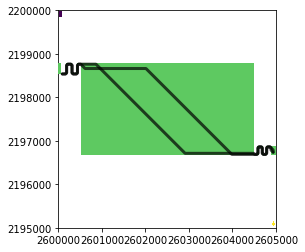

In [2]:
cost_surface_path = os.path.join("data", "synthetic.tif")
source_coord = (2600080, 2198530)
target_coord = (2604933, 2196749)

cost_s_to_t, ls_s_to_t  = calc_least_cost_path(path=cost_surface_path,
                             band=1,
                             source_coord=source_coord, 
                             target_coord=target_coord,
                             matrix=default_lattice)

cost_t_to_s, ls_t_to_s  = calc_least_cost_path(path=cost_surface_path,
                             band=1,
                             source_coord=target_coord, 
                             target_coord=source_coord,
                             matrix=default_lattice)

plot_result([ls_s_to_t, ls_t_to_s], cost_surface=cost_surface_path)

## Aufgabe 2

Bis jetzt haben wir angenommen, dass die Kosten der Kante zwischen zwei Zellen, unabhängig der Richtung, gleich ist. D.h. die Kosten um von Zelle A zu Nachbarzelle B zu kommen, sind die gleichen, wie von Zelle B zu Zelle A. Mit dieser Annahme können wir jedoch nicht alle Probleme lösen.

Zum Beispiel:
* Ein Auto benötigt mehr Energie wenn es aufwärte fährt als wenn es abwärts fährt. D.h. der Energieverbrauch ist abhängig der Fahrtrichtung (und natürlich der Topographie).
* Die maximale Geschwindigkeit eines Segelbotes in eine bestimmte Richtung zu segeln ist nicht nur abhängig von der Windstärke, sondern auch der Windrichtung.

**Überlegen Sie sich, wie Sie den Least Cost Path Algorithmus verändern müssen, um diese Art von Problemen lösen zu können.**


## Aufgabe 3

Bis jetzt haben wir angenommen, dass der least cost path eine kontinuierliche Verbindung von Zellen von Start zu Ziel sein muss. Im Falle von Stromleitungen könnte man aber argumentieren, dass nur die Positionen der Masten relevant sind. Zum Beispiel darf ein Mast nicht auf einer Strasse platziert werden, aber eine Stromleitung darf über eine Strasse führen. Es muss aber ein Minimal-, bzw. Maximalabstand zwischen Masten eingehalten werden. 

**Überlegen Sie sich, wie Sie den Least Cost Path Algorithmus verändern müssen, um diese Art von Problemen lösen zu können.**
